In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

t = time.time()

In [2]:
class Modelisation():
    def __init__(self, X, y, model, scaling=True):
        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_f1 = metrics.f1_score(y_pred, y_test)
        sc_recall = metrics.recall_score(y_pred, y_test)
        sc_precision = metrics.precision_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 
                         'balanced_accuracy': sc_balanced_accuracy, 
                         'f1': sc_f1,
                         'recall': sc_recall,
                         'precision': sc_precision,
                         'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score

    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()     
    
    def show_metrics_score(self):
        for key, value in self.metrics_score.items():
            print(f"{key} : {value:.4f}")
            
    def show_ROC(self):
        fpr, tpr, _ = metrics.roc_curve(self.y_test, self.probs)
        plt.plot(fpr, tpr, label=f"{self.model}")
        plt.plot([0, 1], [0, 1], "r-", label='Modèle aléatoire')
        plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Modèle parfait')
        plt.legend()
        plt.title('Courbe ROC')
        plt.show()

In [3]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 50)

## Variables quantitatives

In [4]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'valueperclick',
 'display_size',
 'zonecostineuro']

X = df[columns_quant]
y = df['is_display_clicked']

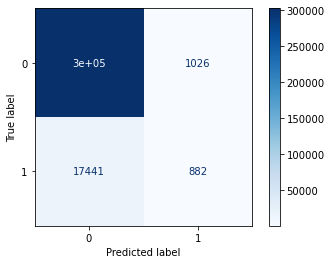

accuracy : 0.9427
balanced_accuracy : 0.7039
f1 : 0.0872
recall : 0.4623
precision : 0.0481
roc_auc : 0.7388


In [5]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

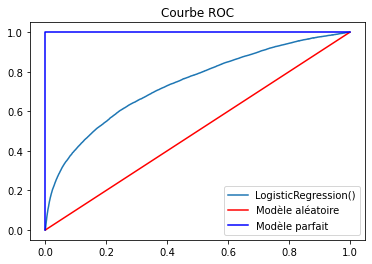

In [6]:
m.show_ROC()

In [7]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,0.042341
campaignctrlast24h,0.220105
dayssincelastvisitdouble,-0.088046
ltf_nbglobaldisplay_4w,0.005739
ltf_nbpartnerdisplayssincelastclick,-0.029956
ltf_nbpartnerdisplay_90d,-0.007426
ltf_nbpartnerclick_90d,0.029130
ltf_nbpartnersales_90d,-0.006323
nbdayssincelastclick,-0.122559
nbdisplay_1hour,-0.195846


In [8]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ = add_constant(X)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.195965
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610479
Method:                           MLE   Df Model:                           14
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.1033
Time:                        18:50:10   Log-Likelihood:            -3.1560e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.2611      0.0

Avec LASSO : 

In [9]:
X1 = df[['contextid',
         'dayssincelastvisitdouble',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

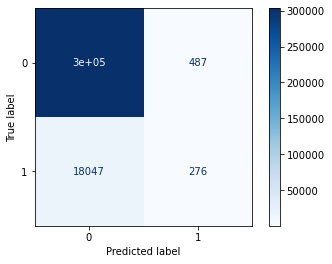

accuracy : 0.9425
balanced_accuracy : 0.6528
f1 : 0.0289
recall : 0.3617
precision : 0.0151
roc_auc : 0.6820


In [10]:
m1 = Modelisation(X1, y1, LogisticRegression())
m1.show_conf_matrix()
m1.show_metrics_score()

# Categorical variables

In [11]:
columns_cat = ['contextid',
            'display_env',
            'target_env',
#             'user_country', 
            'campaignscenario',
            'campaignvertical',
            'is_interstitial',
            'device_type']

In [12]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

contextid : 9
display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7


In [13]:
df_cat = pd.get_dummies(df[columns_cat], columns=columns_cat, drop_first=True)
len(df_cat.columns)

29

In [14]:
X = df_cat
y = df['is_display_clicked']

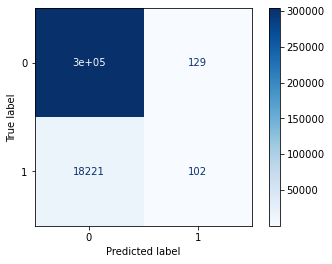

accuracy : 0.9430
balanced_accuracy : 0.6925
f1 : 0.0110
recall : 0.4416
precision : 0.0056
roc_auc : 0.6926


In [15]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

## Quantitative + categorical

In [16]:
df_temp = df[columns_quant + columns_cat]
df_temp = pd.get_dummies(df_temp, columns=columns_cat, drop_first=True)
len(df_temp.columns)

50

In [17]:
X = df_temp
y = df['is_display_clicked']

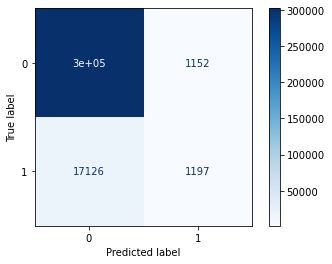

accuracy : 0.9433
balanced_accuracy : 0.7280
f1 : 0.1158
recall : 0.5096
precision : 0.0653
roc_auc : 0.7583


In [18]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

In [19]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:00:52
